In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils

In [2]:
cmap = sns.color_palette("Blues")
# Properties
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dir = '/content/drive/MyDrive/dataset/Training'
test_dir = '/content/drive/MyDrive/dataset/Testing'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)

Found 3212 files belonging to 4 classes.
Using 2570 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3212 files belonging to 4 classes.
Using 642 files for validation.


In [6]:
normalization_layer = layers.Rescaling(1./255)

In [7]:
class_names=train_ds.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

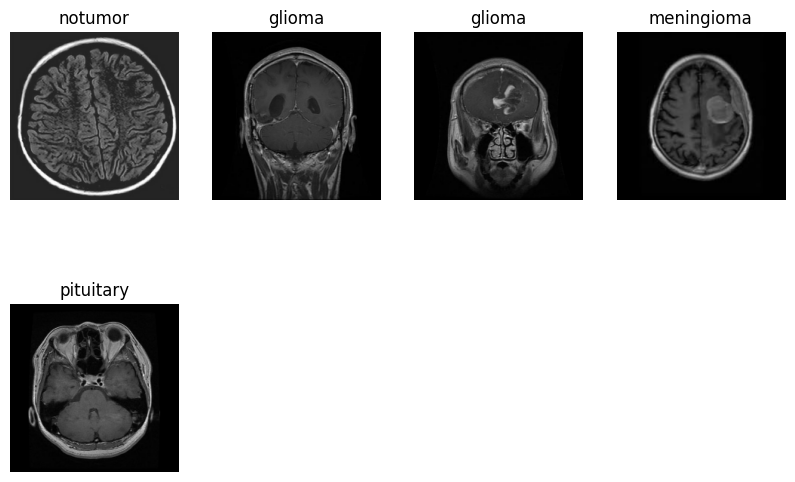

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_ds.take(1):
    for i in range(5):
        ax=plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


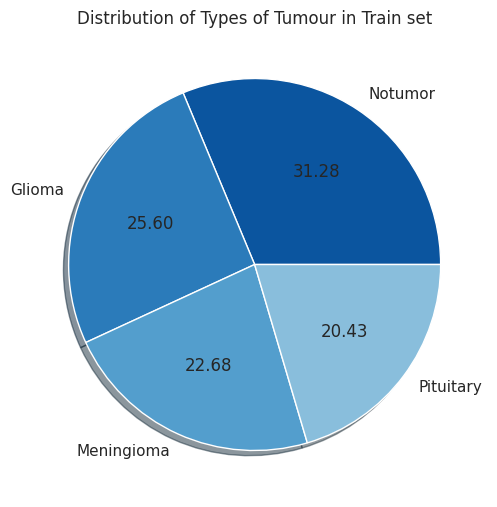

In [10]:
train_ds_labels = []

for _, labels in train_ds:
    for i in range(len(labels)):
        train_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': train_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our training data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True, autopct='%.2f', colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Train set")
plt.show()

In [11]:
model=keras.Sequential([
    normalization_layer,
    layers.Conv2D(64, 3,input_shape=(224,224,3),padding="same"),
    layers.Activation(tf.nn.relu),
    layers.Conv2D(64, 3),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3,padding="same"),
    layers.Activation(tf.nn.relu),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Conv2D(64, 3),
    layers.Activation(tf.nn.relu),
    layers.MaxPooling2D((2,2),strides=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Conv2D(64, 3),
    layers.Activation(tf.nn.relu),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512),
    layers.Activation(tf.nn.relu),
    layers.BatchNormalization(),
    layers.Dense(4, name="outputs")
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
    
)

Epoch 1/5
81/81 [==============================] - 2828s 35s/step - loss: 0.6772 - accuracy: 0.8261 - val_loss: 2.0416 - val_accuracy: 0.4081
Epoch 2/5
81/81 [==============================] - 2676s 33s/step - loss: 0.2480 - accuracy: 0.9163 - val_loss: 4.6742 - val_accuracy: 0.3801
Epoch 3/5
81/81 [==============================] - 2665s 33s/step - loss: 0.1356 - accuracy: 0.9584 - val_loss: 2.6132 - val_accuracy: 0.5016
Epoch 4/5
81/81 [==============================] - 2679s 33s/step - loss: 0.0691 - accuracy: 0.9786 - val_loss: 1.3310 - val_accuracy: 0.4860
Epoch 5/5
81/81 [==============================] - 2674s 33s/step - loss: 0.0375 - accuracy: 0.9883 - val_loss: 3.3920 - val_accuracy: 0.3178


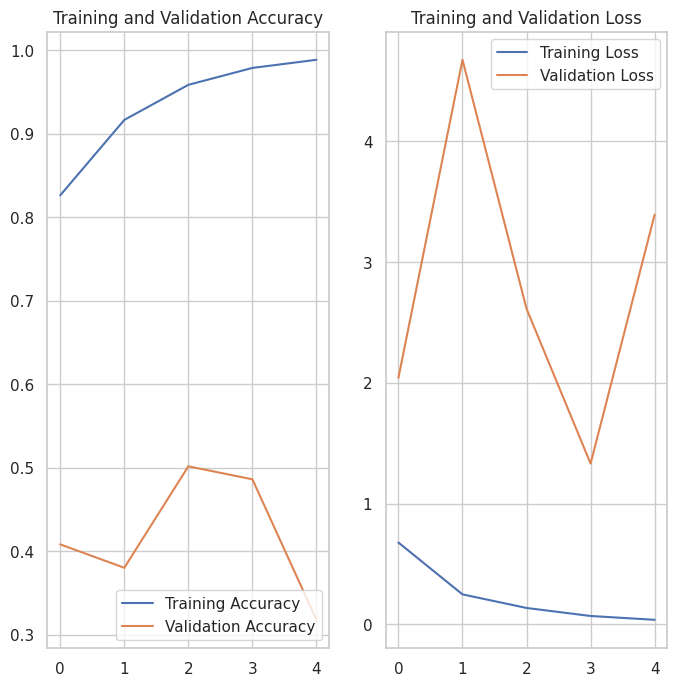

In [14]:
epochs = len(history.epoch) # epochs completed by early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()